In [32]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [33]:
# read in all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [34]:
len(words)

32033

In [35]:
# build the vocabulary of characters and mappings to/from integers 
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['.'] = 0 
itos = {i:c for c,i in stoi.items()}
print(itos)
vocab_size = len(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [36]:
# build the train/test/split 
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size 
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), '--->', ch)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [37]:
g = torch.Generator().manual_seed(2147483647)
dimensions = 10
neurons = 200
C = torch.randn((vocab_size, dimensions),           generator=g)
W1 = torch.randn((dimensions*block_size, neurons),  generator=g) * (5/3)/((dimensions*block_size)**0.5)
b1 = torch.randn(neurons,                           generator=g) * 0.01
W2 = torch.randn((neurons, vocab_size),             generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

bngain = torch.ones((1, neurons))
bnbias = torch.zeros((1, neurons))
bnmean_running = torch.zeros((1, neurons))
bnstd_running = torch.ones((1, neurons))

params = [C, W1, b1, W2, b2, bngain, bnbias]
for p in params:
    p.requires_grad_()

print(sum(p.nelement() for p in params))

12297


In [38]:
stepi = []
lossi = []
training_steps = 200000

for i in range(training_steps):
    # minibatch 
    batch_size = 32
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact-bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix]) 

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < (training_steps * 0.5) else 0.01 
    for p in params:
        p.data -= lr * p.grad

    stepi.append(i)
    lossi.append(loss.log().item())

    if i % 1000 == 0:
        print(f'{i:6d}/{training_steps:6d}: {loss.item():.4f}')

     0/200000: 3.3122
  1000/200000: 2.3909
  2000/200000: 2.3912
  3000/200000: 2.6477
  4000/200000: 2.6462
  5000/200000: 2.2295
  6000/200000: 2.5833
  7000/200000: 2.3082
  8000/200000: 2.8182
  9000/200000: 2.3733
 10000/200000: 2.2111
 11000/200000: 2.3752
 12000/200000: 2.3259
 13000/200000: 2.2423
 14000/200000: 1.9972
 15000/200000: 2.3098
 16000/200000: 2.1040
 17000/200000: 2.2694
 18000/200000: 2.1678
 19000/200000: 2.1466
 20000/200000: 1.7505
 21000/200000: 2.2864
 22000/200000: 2.1587
 23000/200000: 2.1734
 24000/200000: 2.3405
 25000/200000: 2.2699
 26000/200000: 2.6849
 27000/200000: 2.3408
 28000/200000: 2.4404
 29000/200000: 2.2779
 30000/200000: 2.2093
 31000/200000: 2.6098
 32000/200000: 2.0739
 33000/200000: 2.2378
 34000/200000: 1.7758
 35000/200000: 1.9845
 36000/200000: 1.9401
 37000/200000: 1.8825
 38000/200000: 2.3364
 39000/200000: 2.4476
 40000/200000: 2.1898
 41000/200000: 2.1800
 42000/200000: 2.1276
 43000/200000: 2.0864
 44000/200000: 2.4036
 45000/200

In [39]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')


split_loss('train')
split_loss('val')

train loss: 2.0671
val loss: 2.1067


In [40]:
# sample fom the model 
g = torch.Generator().manual_seed(2147483647)
for _ in range(1000):
    out = []
    context = [0] * (block_size-1) + [1]
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break   
    
    print('a' + ''.join([itos[i] for i in out[:-1]]))

ardez
arloslyuriccarlardnn
arlisstta
anylandkikasdr
arnsz
aphllbuhrygotts
ardziddlyc
agkairedagtal
ardtzsedgh
ankaviorghn
absthfinncesvtrrlysukhshrddn
arilhp
antailansimf
adrn
ardz
arykest
ariyatth
aikalbhudbsrathbrunethlylbmarlithahdrlengwmalfk
ardthav
aztob
arysonhlistjanncelghnishriyennlyimewfnrdieban
arzisammagabrxemmulisschfrcallynn
anjanncisanahvannchnsleya
arnstavictotthi
aashdugnnchusshfranz
aabhlisanncyettrcarrwbb
ardubrkarrennnfahdrisaddhukwt
aghn
ardiebagrliklmichurtz
anthaydivnngitgossly
amerjannchanirikhprtww
azyah
anizgerzdevjuttblossticxlkismjaantz
ariahw
arvegustcfalnnfsrifeffronsellaj
aristhvanhynskilkwlscynn
aasudswil
ardhanshinssanffredirghanncianquosb
akdrn
aaslarshanzmorghnilannahdikelsskfbrzerragwl
anclscyannchvp
alcioluwoh
axnicainethd
arassawwun
arrchmrnold
ardtdylehsir
axlynn
arthm
antalmard
abnkisobtrfighnnchjannchoppnn
ardielkezgistdn
aatiyardyeshannzliffrcccenzsepphrzkhylenngelseff
aahdrn
aabhldayna
ariansellizandra
aabggangi
aantva
arvixhnckoluwz
aabdsobdn


In [291]:
# pytorch implementation!
class Linear: 
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) # / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out 
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps 
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (not trained with backprop)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            # calculate the mean and variance on the batch
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else: 
            xmean = self.running_mean
            xvar = self.running_var
        # normalize the batch
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [305]:
n_emb = 10 # the dimension of the embedding
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain 
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= 1 # 5/3

parameters = [C] + [p for l in layers for p in l.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad_()

# same optimization as last time 
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y 

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for l in layers:
        x = l(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph 
    for p in parameters:
        p.grad = None
    loss.backward()

    # update    
    lr = 1 if i < (max_steps * 0.5) else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats 
    if i % 1000 == 0:
        print(f'{i:6d}/{max_steps:6d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER DEBUG: would take out obviously to run full optimization 


47551
     0/200000: 3.2870
  1000/200000: 2.3263


layer 2 (      Tanh): mean -0.00, std 0.633348, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.632525, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.636294, saturated: 2.34%
layer 11 (      Tanh): mean -0.00, std 0.635893, saturated: 2.62%
layer 14 (      Tanh): mean +0.00, std 0.635583, saturated: 2.50%


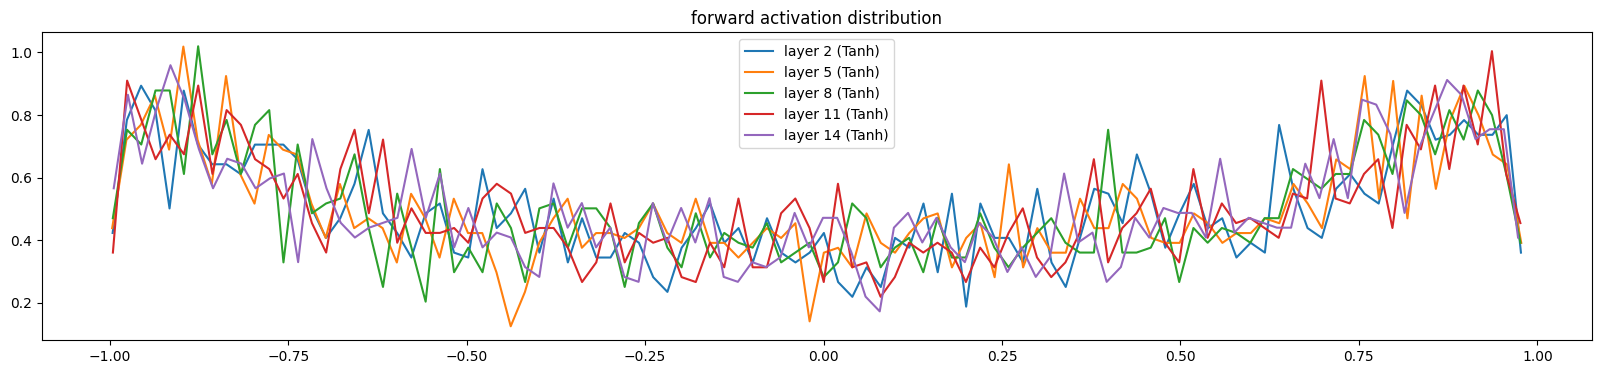

In [298]:
# visualize histograms 
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out 
        print('layer %d (%10s): mean %+.2f, std %.6f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (torch.abs(t) > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('forward activation distribution');

layer 2 (      Tanh): mean +0.00, std 0.003094, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.002661, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.002426, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.002269, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.001983, saturated: 0.00%


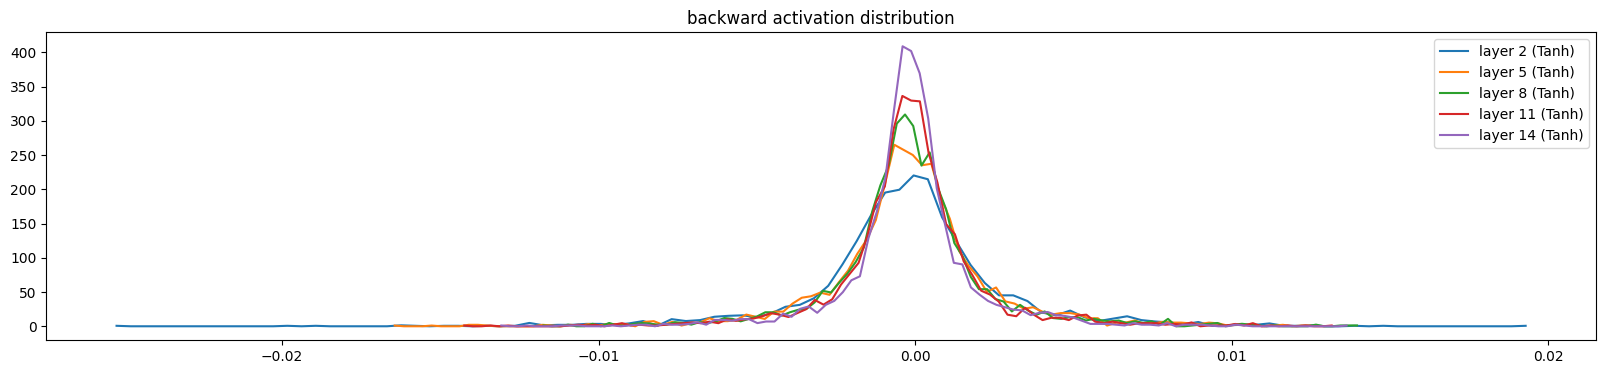

In [299]:
# visualize histograms 
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad 
        print('layer %d (%10s): mean %+.2f, std %.6f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (torch.abs(t) > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('backward activation distribution');

weight   (27, 10) | mean 0.000000 | std 6.705947e-03 | grad:data ratio 6.700179e-03
weight  (30, 100) | mean -0.000003 | std 2.026517e-03 | grad:data ratio 1.977298e-03
weight (100, 100) | mean 0.000013 | std 1.104427e-03 | grad:data ratio 1.108056e-03
weight (100, 100) | mean 0.000005 | std 9.566544e-04 | grad:data ratio 9.497149e-04
weight (100, 100) | mean 0.000003 | std 8.406345e-04 | grad:data ratio 8.380438e-04
weight (100, 100) | mean 0.000001 | std 7.872586e-04 | grad:data ratio 7.840729e-04
weight  (100, 27) | mean -0.000002 | std 1.212761e-03 | grad:data ratio 1.226612e-03


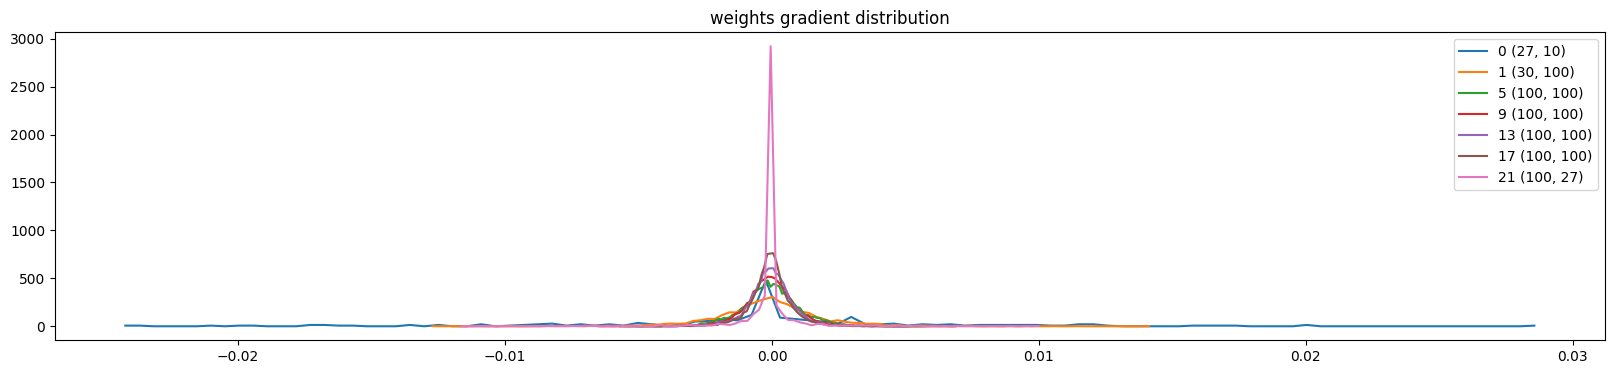

In [300]:
# visualize histograms 
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad 
    if p.ndim == 2:
        print('weight %10s | mean %f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), (t.std() / p.std())))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

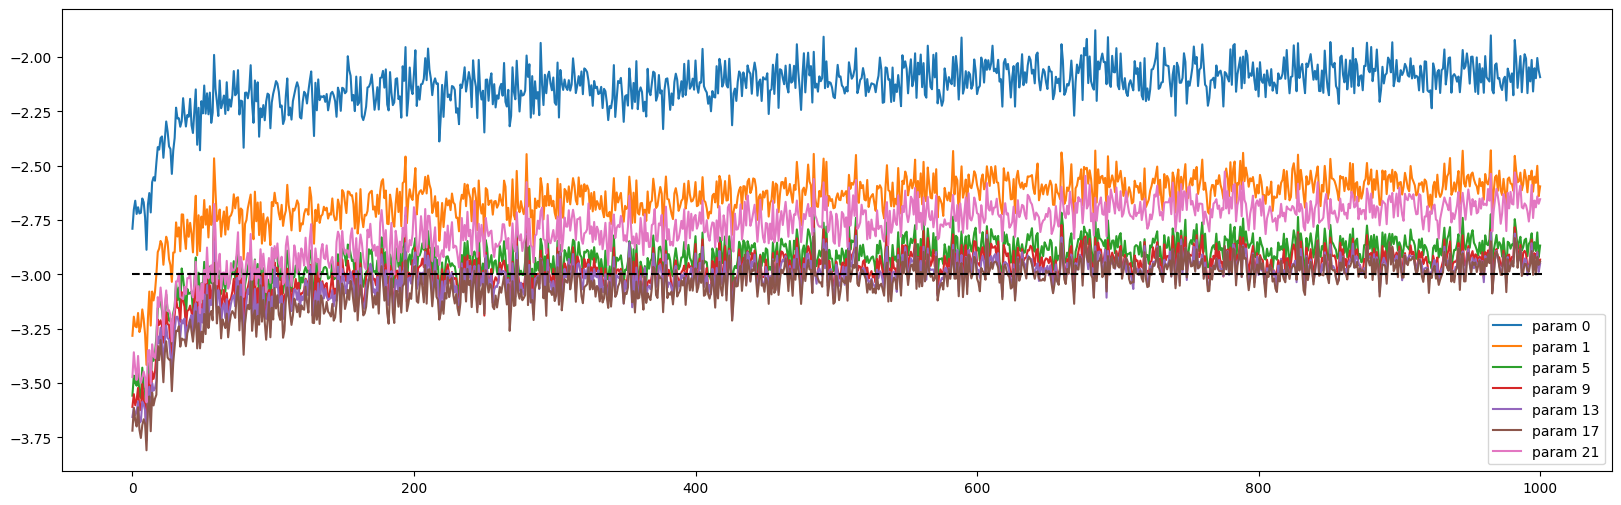

In [306]:
plt.figure(figsize=(20, 6))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k--') # these ratios should be ~1e-3, indicate on plot 
plt.legend(legends);

tensor(0.9903)


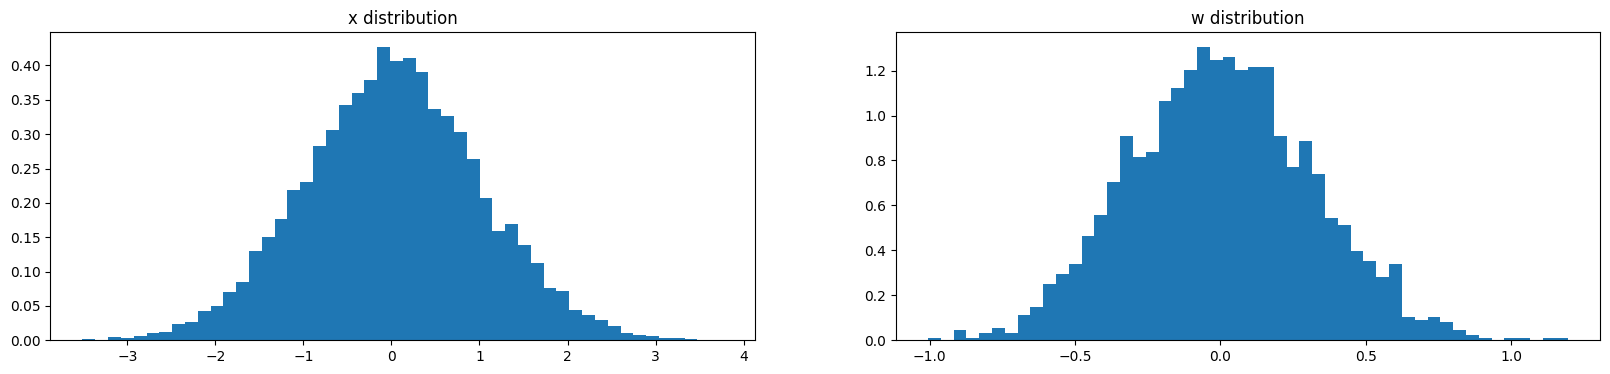

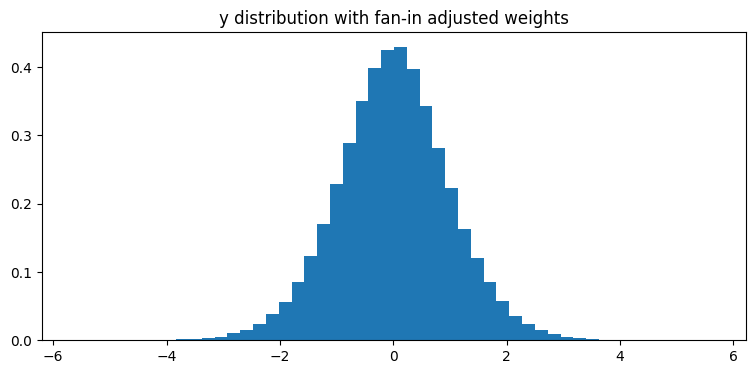

In [302]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1), bins=50, density=True);
plt.title('x distribution');

plt.subplot(1, 2, 2)
plt.hist(w.view(-1), bins=50, density=True);
plt.title('w distribution');

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.hist(y.view(-1), bins=50, density=True);
plt.title('y distribution with fan-in adjusted weights');

print(y.std())

tensor(0.7442)


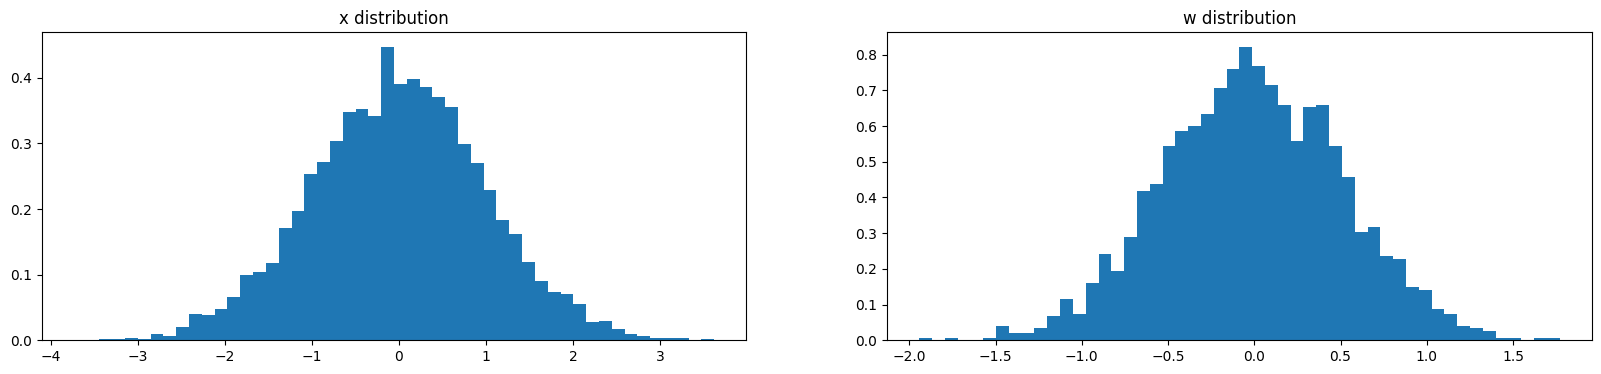

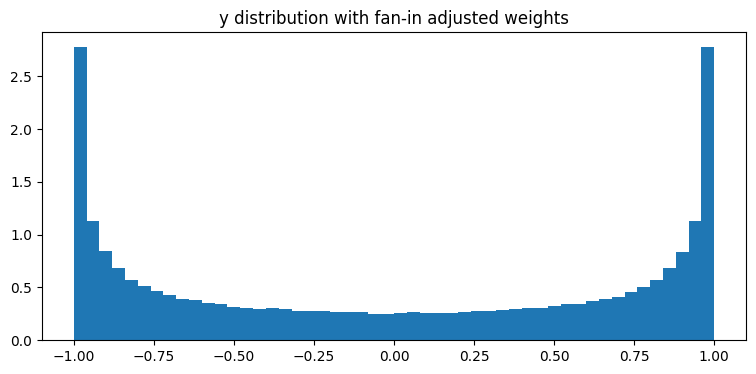

In [48]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * (5/3) / (10**0.5)
y = torch.tanh(x @ w)

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1), bins=50, density=True);
plt.title('x distribution');

plt.subplot(1, 2, 2)
plt.hist(w.view(-1), bins=50, density=True);
plt.title('w distribution');

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.hist(y.view(-1), bins=50, density=True);
plt.title('y distribution with fan-in adjusted weights');

print(y.std())